In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def CSPSA(psi_est, nu_ite, fun_teor, fun,
          s=1, t=1/6, a=3, A=1, b = 0.1 ):
    """
    CSPSA
    IN
        psi_est: dim x n_par matrix. dim is de dimension of each vector, and n_par
                the number of guesses in parallel.
        nu_ite: int. Number of iterations of CSPSA.
        fun_teor: function. It is the known function, for example, the theoretical
                 fidelity between the unknown state of the system and the guess.
        fun: function. CSPSA uses this function for the optimization.
        s, t, a, A, b: parametros CSPSA
    OUT
        valor_optimo: real. Optimal value of fun finded by CSPSA.
    """

    n_par = int(psi_est.size/psi_est.shape[0])
    valor_optimo = np.zeros((n_par, nu_ite))
    valor_optimo[:,0] = fun_teor(psi_est)

    for k in range(0,nu_ite-1):
        valor_optimo[:,k+1], psi_est = (itCSPSA(psi_est/np.linalg.norm(psi_est, axis = 0),
                                       k, s, t, a, A, b, fun, fun_teor ))


    return valor_optimo

In [3]:
def itCSPSA(z_k,  k, s, t, a, A, b, fun, fun_teor):
    """iteracion de CSPSA
    IN
        z_k: dim x n_rep. Cada columna es un estimador de dimension dim.
        k: iteracion
        s, t, a, A, b: parametros CSPSA
        fun: funcion a optimizar
    OUT
        z_k: dim x n_rep. Estimador actualizado
        z_value: real. valor de fun en el estimador z_k
    """
    dim = z_k.shape[0]
    rep = int(z_k.size/z_k.shape[0])
    alpha = a/(k+1+A)**s
    beta = b/(k+1)**t
    delta = (1j)**(np.random.randint(1,5,(dim, rep))).reshape(2,rep)
    z_k_mas = z_k + beta*delta
    z_k_menos = z_k - beta*delta
    fun_k_mas = fun(z_k_mas)
    fun_k_menos = fun(z_k_menos)
    grad = np.divide(fun_k_mas - fun_k_menos, 2*beta*delta.conj())
    z_k = z_k - alpha*grad
    z_value = fun_teor(z_k)
    return z_value, z_k

In [4]:
def SPSA(psi_est, nu_ite, fun_teor, fun,
          s=1, t=1/6, a=3, A=1, b = 0.1 ):
    """
    SPSA
    IN
        psi_est: dim x n_par matrix. dim is de dimension of each vector, and n_par
                the number of guesses in parallel.
        nu_ite: int. Number of iterations of SPSA.
        fun_teor: function. It is the known function, for example, the theoretical
                 fidelity between the unknown state of the system and the guess.
        fun: function. SPSA uses this function for the optimization.
        s, t, a, A, b: parametros SPSA
    OUT
        valor_optimo: real. Optimal value of fun finded by SPSA.
    """

    n_par = int(psi_est.size/psi_est.shape[0])
    valor_optimo = np.zeros((n_par, nu_ite))
    valor_optimo[:,0] = fun_teor(psi_est)

    for k in range(0,nu_ite-1):
        valor_optimo[:,k+1], psi_est = (itSPSA(psi_est/np.linalg.norm(psi_est, axis = 0),
                                       k, s, t, a, A, b, fun, fun_teor ))


    return valor_optimo

In [5]:
def itSPSA(z_k,  k, s, t, a, A, b, fun, fun_teor):
    """iteracion de SPSA
    IN
        z_k: dim x n_rep. Cada columna es un estimador de dimension dim.
        k: iteracion
        s, t, a, A, b: parametros SPSA
        fun: funcion a optimizar
    OUT
        z_k: dim x n_rep. Estimador actualizado
        z_value: real. valor de fun en el estimador z_k
    """
    dim = z_k.shape[0]
    rep = int(z_k.size/z_k.shape[0])
    alpha = a/(k+1+A)**s
    beta = b/(k+1)**t
    
    #Cambiamos un delta complejo por uno real (+1,-1)
    
    delta = (-1)**(np.random.randint(1,5,(dim, rep))).reshape(2,rep)
    delta_i = (-1)**(np.random.randint(1,5,(dim, rep))).reshape(2,rep)
    
    #Definimos parte real e imaginaria
    
    z_k_mas_r = np.real(z_k) + beta*delta
    z_k_mas_i = np.imag(z_k) + beta*delta_i
    z_k_menos_r = np.real(z_k) - beta*delta
    z_k_menos_i = np.imag(z_k) - beta*delta_i
    
    #Nuevo estado, normalizado
    
    z_k_mas = z_k_mas_r +1j*z_k_mas_i
    z_k_menos = z_k_menos_r+1j*z_k_menos_i
    
    z_k_mas = z_k_mas/np.linalg.norm(z_k_mas, axis=0)
    z_k_menos = z_k_menos/np.linalg.norm(z_k_menos, axis=0)
    
    fun_k_mas = fun(z_k_mas)
    fun_k_menos = fun(z_k_menos)
    
    #Gradiente real e imaginaria
    
    grad = np.divide(fun_k_mas - fun_k_menos, 2*beta*delta)
    grad_i = np.divide(fun_k_mas - fun_k_menos, 2*beta*delta_i)
    
    z_k = z_k - alpha*grad - 1j*alpha*grad_i
    z_k = z_k/np.linalg.norm(z_k, axis=0)
    
    z_value = fun_teor(z_k)
    return z_value, z_k

In [6]:
# Definir Estado

def estado(dim, n_par):
    psi = (np.random.normal(loc=0.0, scale=1.0,
           size=(dim, n_par))
           + np.random.normal(loc=0.0, scale=1.0,
           size=(dim, n_par))*1j)
    psi = psi/np.linalg.norm(psi, axis=0)
    return psi

In [7]:
# Definir Hamiltoniano

def H_paul (A,B,C):
    pauli_x = np.array((((0, 1), (1, 0))))
    pauli_y = np.array((((0, -1j), (1j, 0))))
    pauli_z = np.array((((1, 0), (0, -1))))
    H_paul = A*pauli_x + B*pauli_y + C*pauli_z
    return H_paul

In [8]:
# Definir Valor de expectacion

def exp_H (psi_est, H):
    psi = np.matrix(psi_est)
    psi = psi/np.linalg.norm(psi, axis=0)
    psi_dagger = psi.getH()
    H = np.matrix(H)
    exp_H = psi_dagger*H*psi
    return exp_H

In [9]:
d = 2
nu_par = 1
NU_ITERACIONES = 800

#A = np.sqrt(0.3)
#B = np.sqrt(0.2)
#C = np.sqrt(0.5)
A = 1
B = 3
C = 5

In [10]:
psi_est = estado(d,nu_par)


In [11]:
H = H_paul(A,B,C)


In [12]:
fun = lambda x : exp_H(x, H)


In [13]:
# Ground-state Teórico

E = A**2 + B**2 + C**2

const1 = np.sqrt(1/2) * np.sqrt((A**2+B**2)/(E-C*(np.sqrt(E))))
const2 = (C-np.sqrt(E))/(A+1j*B)

#psi_teo = const1*np.matrix([[const2], [1]])
#fun(psi_teo)

Ground_teo = -(np.sqrt(A**2 + B**2 + C**2))
print(Ground_teo)

-5.916079783099616


In [14]:
Result_CSPSA = CSPSA(psi_est, NU_ITERACIONES, fun, fun)

/home/dmunoz/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/home/dmunoz/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: ComplexWarning: Casting complex values to real discards the imaginary part


In [15]:
Result_SPSA = SPSA(psi_est, NU_ITERACIONES, fun, fun)

/home/dmunoz/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/home/dmunoz/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: ComplexWarning: Casting complex values to real discards the imaginary part


In [16]:
error_CSPSA = abs(Result_CSPSA - Ground_teo)
error_SPSA = abs(Result_SPSA - Ground_teo)

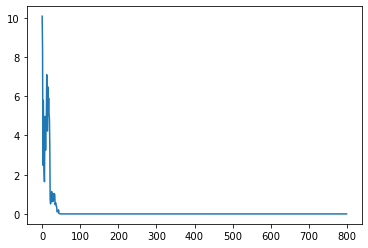

In [17]:
plt.plot(np.array(error_CSPSA[:]).T)
#plt.loglog(np.array(error_CSPSA[:]).T)

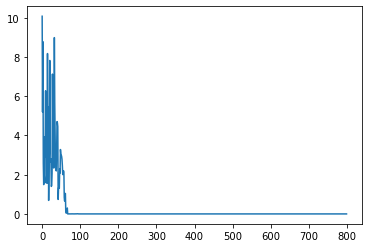

In [18]:
#plt.loglog(np.array(error_SPSA[:]).T)
plt.plot(np.array(error_SPSA[:]).T)

In [19]:
np.savetxt('prueba.txt', Result_SPSA, delimiter=',')
print(Result_SPSA)

[[ 4.1649735  -0.71916624  2.86584937 -3.32915918 -4.42237601 -4.19488651
  -1.9798397  -3.0247741  -2.31755066  0.36170517 -4.3278475  -4.21071673
  -3.9541812  -4.34984391  2.26231388 -2.49945901 -0.45643975 -5.22754472
  -3.34035851 -2.76777179  1.90989222 -3.2718231  -3.27120162 -3.11084358
  -4.51388353 -4.46847229 -3.84476078  1.21511883 -1.34475528 -1.37068705
  -3.56945406 -3.5686797   3.07521397 -0.26135577 -2.08809931 -3.45357147
  -2.47644634 -3.72467212 -2.72176174 -1.20925806 -1.26993207 -1.46154582
  -5.17763773 -4.57657586 -4.58386314 -4.60604771 -3.60893005 -3.83499039
  -2.6327293  -2.87166002 -2.91254412 -2.97553283 -3.1195946  -3.44311429
  -3.91048998 -3.7747306  -3.71327068 -3.77889481 -5.079375   -5.26234481
  -4.88042767 -4.87239835 -5.84766407 -5.87240542 -5.873511   -5.84178367
  -5.61372099 -5.91483268 -5.91523392 -5.91528037 -5.91566423 -5.91556664
  -5.91554212 -5.91557737 -5.91546433 -5.915371   -5.91534138 -5.91296183
  -5.91281966 -5.91401556 -5.91606856 

In [20]:
np.savetxt('prueba.txt', Result_CSPSA, delimiter=',')
print(Result_CSPSA)

[[ 4.1649735   2.5219222  -3.4317141  -0.12342607 -1.81299672 -3.69571485
  -4.27332272 -1.96735191 -0.94215122 -2.66313677 -1.02168857 -1.01642395
   1.18056035 -1.67514767 -1.68695616  0.56013029 -0.70283768 -0.00967472
  -0.77997572 -1.02361427 -2.36124554 -5.16319283 -5.40336434 -5.2229079
  -5.25080493 -4.77891828 -5.12425135 -4.97026378 -5.29316528 -4.88438049
  -5.20493327 -4.87696947 -4.94829307 -4.92549968 -5.44077041 -5.35777764
  -5.35944559 -5.52393862 -5.5384362  -5.80915788 -5.81204532 -5.80890767
  -5.80360341 -5.70881445 -5.8965789  -5.9020671  -5.90833943 -5.90957674
  -5.91483504 -5.9155526  -5.91601601 -5.91592284 -5.91563696 -5.91578846
  -5.91579519 -5.91579312 -5.91573228 -5.91571971 -5.91566217 -5.91601645
  -5.91593818 -5.91604494 -5.91602788 -5.91601914 -5.91602824 -5.91604428
  -5.91595376 -5.91593821 -5.91592933 -5.9160055  -5.91600158 -5.9160059
  -5.91595861 -5.91601733 -5.91601084 -5.91596172 -5.9159566  -5.91595329
  -5.91601633 -5.91600112 -5.91600864 -5

In [21]:
print(psi_est)
fun(psi_est)

[[0.3728822 -0.68551934j]
 [0.62268731+0.05729399j]]


matrix([[4.1649735+0.j]])